In [8]:
import torch.nn as nn
import torch 
import random 
import gym
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from actor_critic import ActorCritic


def run_episodes_policy_gradient(env, num_episodes, max_steps, gamma, learn_rate, nstep=1, n_hidden=256):
    
    n_state_features = len(env.reset())
    n_actions = env.action_space.n
    
    model =  ActorCritic(n_state_features, n_actions, n_hidden)
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []

    # loop for each episode
    for episode in tqdm(range(num_episodes)):
        
        # initialize S (first state of episode)
        s = env.reset()
        I = 1
        step = 0

        T = float('inf')
        t = 0
        
        states  = [s] # S_0, S_1, ...
        rewards = []  # R_1, R_2, ...
        
        while True:
            
            if t < T:
                with torch.no_grad():
                    _, pi_s_a = model.forward(s) 
            
                # select action
                a = torch.multinomial(pi_s_a, 1).item()  
                log_prob = torch.log(pi_s_a.squeeze(0)[a])
            
                # take action
                s_new, r, done, _ = env.step(a) 
                rewards.append(r)
                states.append(s_new) 
                
                if done:
                    T = t + 1 
            
            tau = t - nstep + 1 

            if tau >= 0:
                
                # compute G
                G = np.sum(gamma**(i-tau) * rewards[i] 
                           for i in range(tau, min(tau+nstep, T)))
                
                if tau + nstep < T: 
                    with torch.no_grad():   
                        v_s_new, _ = model.forward(s_new)
                        G += (gamma**nstep) * v_s_new.item()
                
                # update model for state s_tau
                state_tau = states[tau]
                v_tau, pi_s_a_tau = model.forward(state_tau)
                log_prob_tau = torch.log(pi_s_a_tau.squeeze(0)[a])
                
                # compute loss
                delta = G - v_tau
                loss_a =  - delta * I * log_prob_tau
                loss_c =  - delta * v_tau 
                loss = loss_a + loss_c

                # backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                #print('t:', t, 'v_s_t:',v_s.item(), 'v_s_t+1:', v_s_new.item(), 
                #    'tau:', tau, 'G:', G, 'delta:', delta, 'done:', done)
            
            # update episode and records
            s = s_new
            t += 1
            I = gamma*I
            
            if tau == T - 1:
                break
            
        if episode % 10 == 0:
            #print("E{0}- Steps:{1} Loss:{2}".format(episode, t, loss))
            pass
                  
        episode_durations.append(t)
        
    return episode_durations

100%|██████████| 2000/2000 [04:30<00:00,  5.52it/s]


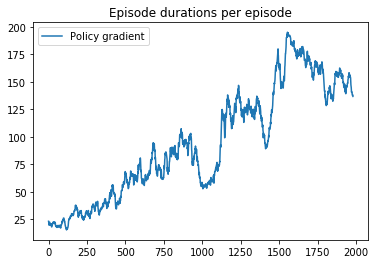

In [12]:
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

num_episodes = 2000
discount_factor = 0.99
learn_rate = 0.0001
seed = 42
random.seed(seed)
torch.manual_seed(seed)

env = gym.envs.make("CartPole-v0")
env.seed(seed)

max_steps =  200 # Note: CartPole stops after 200 steps

episode_durations_policy_gradient = run_episodes_policy_gradient(env, 
                                                                 num_episodes, 
                                                                 max_steps,
                                                                 discount_factor, 
                                                                 learn_rate,
                                                                 nstep=1,
                                                                 n_hidden=256)
plt.plot(smooth(episode_durations_policy_gradient, 20))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

100%|██████████| 2000/2000 [01:55<00:00, 17.29it/s]


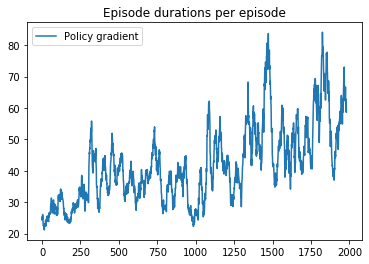

In [13]:
episode_durations_policy_gradient = run_episodes_policy_gradient(env, 
                                                                 num_episodes, 
                                                                 max_steps,
                                                                 discount_factor, 
                                                                 learn_rate,
                                                                 nstep=3,
                                                                 n_hidden=256)
plt.plot(smooth(episode_durations_policy_gradient, 20))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

# Something is wrong
#            .--.            .--.
#            ( (`\\."--``--".//`) )
#             '-.   __   __    .-'
#              /   /__\ /__\   \
#             |    \ 0/ \ 0/    |
#             \     `/   \`     /
#              `-.  /-"""-\  .-`           ._-.
#                /  '.___.'  \            //';\\
#                \     I     /           //  ;//
#                 `;--'`'--;`            \\_;//
#                   '.___.'               //-`
#                  ___| |___           ."`-.
#               .-`  .---.  `-.       /     )
#              /   .'     '.   \     /      )
#             /  /||       ||\  \   /  /`""`
#            /  / ||       || \  \ /  /
#           /  /  ||       ||  \  /  /
#          /  (___||___.-=--.   \   /
#         (                -;    '-' 
#          `-----------.___~;
#                 ||       ||